In [111]:
import collections as co
import pandas as pd
import numpy as np
import seaborn as sns
import re
from ete3 import PhyloTree, Tree, faces, AttrFace, CircleFace, TreeStyle, NodeStyle, TextFace, RectFace, SequenceFace
from scipy.cluster import hierarchy
import math
from matplotlib import colors

In [3]:
def roundup(x):
    return(int(math.ceil(int(x) / 10.0)) * 10)

In [4]:
def rounddown(x):
    return(int(math.floor(int(x) / 10.0)) * 10)

In [5]:
def getTimespan(year):
    
    try:
        timespan = f'{rounddown(int(year))}-{roundup(int(year))}'
    except:
        timespan = 'NA'#np.nan
    
    return(timespan)

In [59]:
def getHostselection(host, hostdict):
    
    hostsel = ''
    for key in hostdict.keys():
        if re.match('(?:% s)' % '|'.join(hostdict[key]), host, re.IGNORECASE):
            hostsel = key
            break
    if not hostsel:
        hostsel = 'NA'
        #hostsel = host
    
    return(hostsel)

In [68]:
def getNewick(node, newick, parentdist, leaf_names):
    
    if node.is_leaf():
        return(leaf_names[node.id] + ":" + np.format_float_positional(parentdist - node.dist) + newick)
        #return "%s:%.5f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    
    else:
        if len(newick) > 0:
            newick = "):" + np.format_float_positional(parentdist - node.dist) + newick
            #newick = "):%.5f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), "," + newick, node.dist, leaf_names)
        #newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        
        newick = "(" + newick
        #newick = "(%s" % (newick)
        return(newick)

In [181]:
def getTree(framelink, frameclust, framemeta, rownumber = 2, segment = 4, prune = True):
    
    treequery = frameclust.loc[4].join(framemeta)[['cluster', 'hostsel', 'timespan', 'protein', 'subtype']]
    treedict = treequery.to_dict()
    treelabel = treequery.index.values
    treestyle = TreeStyle()
    treelink = framelink.loc[4].drop(columns=['parent']).to_numpy()
    treehierarchy = hierarchy.to_tree(treelink, False)
    treenewick = getNewick(treehierarchy, "", treehierarchy.dist, treelabel)
    
    tree = Tree(treenewick)
    listcluster = list(set(treedict['cluster'].values()))
    listyear = list(set(treedict['timespan'].values()))
    listhost = list(set(treedict['hostsel'].values()))
    listcolor = ['#FF0029','#377EB8','#66A61E','#984EA3','#00D2D5','#FF7F00','#AF8D00','#7F80CD','#B3E900','#C42E60','#A65628','#F781BF','#8DD3C7','#BEBADA','#FB8072','#80B1D3','#FDB462','#FCCDE5']
    
    dictcolor = dict(zip(listhost, listcolor[0:len(listhost)]))
    prunecluster = []
    
    for node in tree.traverse():
        node.img_style["vt_line_width"] = 1
        node.img_style["hz_line_width"] = 1
        node.img_style["vt_line_type"] = 0
        node.img_style["hz_line_type"] = 0
        node.img_style["fgcolor"] = "#000000"
        node.img_style["shape"] = "circle"
        node.img_style["vt_line_color"] = "#000000"
        node.img_style["hz_line_color"] = "#000000"
        node.img_style['bgcolor'] = 'lightgrey'
    
    for leaf in tree.iter_leaves():
        leaf.host = treedict['hostsel'].get(leaf.name, "none")
        leaf.year = treedict['timespan'].get(leaf.name, "none")
        leaf.cluster = treedict['cluster'].get(leaf.name, "none")
        leaf.protein = treedict['protein'].get(leaf.name, "none")
        leaf.subtype = treedict['subtype'].get(leaf.name, "none")
    
    if -1 in listcluster:
        listcluster.remove(-1)
    
    for cluster in listcluster:
        listmember = tree.search_nodes(cluster=cluster)
        nodecluster = tree.get_common_ancestor(listmember)
        nodecluster.name = f'cluster {cluster}'
        nodecluster.size = len(listmember)
        nodecluster.host = co.Counter([member.host for member in listmember]).most_common(1)[0][0]
        
        nodecluster.add_face(AttrFace("name", fsize=10), 0, position="aligned")
        nodecluster.add_face(AttrFace("size", fsize=10, text_prefix='|', text_suffix='|'), 1, position="aligned") 
        nodecluster.img_style['bgcolor'] = dictcolor[nodecluster.host]
        
        prunecluster.append(nodecluster.name)    
        
    if prune == True:
        tree.prune(prunecluster)
        
    treestyle =  TreeStyle()
    treestyle.show_leaf_name = False
    treestyle.draw_guiding_lines = True
    treestyle.guiding_lines_color = 'black'
    treestyle.mode = "c"
    treestyle.allow_face_overlap = False

    column = 0
    for i, host in enumerate(listhost, 1): 
        legendcolor = RectFace(width = 20, height = 20, fgcolor = "#000000", bgcolor = dictcolor[host], label = None)
        treestyle.legend.add_face(legendcolor, column = column)
        legendtext = TextFace(host)
        legendtext.margin_right = 5
        legendtext.margin_left = 1
        treestyle.legend.add_face(legendtext, column = column + 1)

        if i%rownumber == 0:
            column = column + 2

    treestyle.legend_position = 1
        
    return(tree, treestyle)

In [92]:
link = pd.read_csv('linkage.csv', sep = ',', na_filter = False, header = 0)
cluster = pd.read_csv('cluster.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
framelink = link.set_index(keys = 'segment')
frameclust = cluster.reset_index().set_index(keys = ['segment', 'accession']).drop(labels = ['H', 'N'], axis = 1)

In [93]:
exclude = [i for i, line in enumerate(open('A.fasta')) if not line.startswith('>')]
framemeta = pd.read_csv('A.fasta', skiprows = exclude, sep = '|', na_filter = False, header = None)
framemeta.columns = ['accession', 'strain', 'segment', 'protein', 'genus', 'subtype', 'date', 'host', 'curation']
framemeta[['month', 'day', 'year']] = framemeta['date'].apply(lambda x : x if len(re.findall('/', x)) == 2 else (x.split('/')[0] + '/NA/' + x.split('/')[1] if len(re.findall('/', x)) == 1 else 'NA/NA/' + x)).str.split('/', expand=True)
framemeta.set_index(keys = 'accession', inplace = True)

In [94]:
hostdict =	{
    "human": [".*human.*"],
    "duck": [".*duck.*", ".*scaup.*", ".*pochard.*", ".*mallard.*", ".*bufflehead.*", ".*gadwall.*", ".*teal.*", ".*pintail.*", ".*shoveler.*", ".*wigeon.*", ".*pintail.*", ".*godwall.*", ".*goldeneye.*"],
    "bird": [".*murre.*", ".*crane.*", ".*hawk.*", ".*dove.*", ".*parrot.*", ".*dunlin.*", ".*owl.*", ".*shearwater.*", ".*bird.*", ".*grebe.*", ".*pheasant.*", ".*stint.*", ".*sparrow.*", ".*crow.*", ".*sandpiper.*", ".*falcon.*", ".*ostrich.*", ".*stork.*", ".*pigeon.*", ".*turkey.*", ".*sanderling.*", ".*knot.*", ".*quail.*", ".*waterfowl.*", ".*turnstone.*", ".*bird.*", ".*fowl.*", ".*avian.*"],
    "gull": [".*gull.*"],
    "chicken": [".*chicken.*"],
    "cat": [".*cat.*", ".*tiger.*"],
    "bat": [".*bat.*"],
    "swan": [".*swan.*"],
    "swine": [".*swine.*"],
    "equine": [".*equine.*"],
    "dog": [".*dog.*"],
    "goose": [".*goose.*"],
    "horse": [".*horse.*"],
    "environment": [".*environment.*"],
    "NA": [".*unknown.*"],
    "ferret": [".*mink.*", ".*ferret.*", ".*weasel.*"]
}

In [95]:
framemeta['timespan'] = framemeta['year'].apply(lambda x : getTimespan(x))
framemeta['hostsel'] = framemeta['host'].apply(lambda x : getHostselection(x, hostdict))

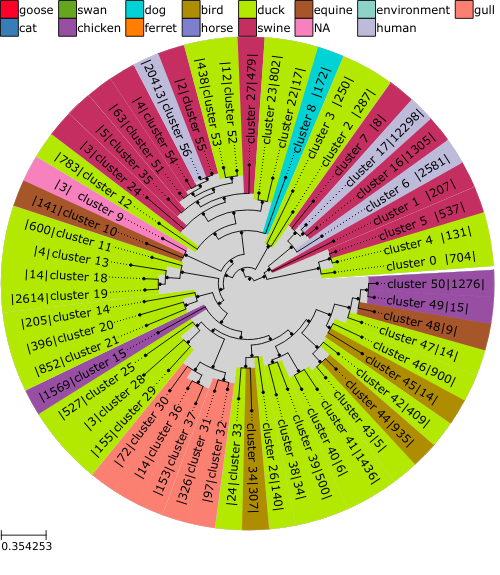

In [183]:
tree, ts = getTree(framelink, frameclust, framemeta, 2, 4, True)
tree.render(file_name = '%%inline', tree_style = ts, w=500)